# Реализация модели для Классификации+Локализации
В этом практическом уроке мы реализуем классификацию и локализацю одного объекта на изображении с помощью свёрточной нейронной сети. Локазизация объекта будет задаваться ограничивающим прямоугольником (4 числа). В качестве данных будем использовать датасает MNIST. Однако, потребуется его модификация, так как исходный датасет предназначен лишь для задачи классификации. Поэтому мы синтезируем новый датасет, в котором будем помещать цифру на некоторый холст бОльшего размера, где её и нужно будет "локализовать".

### Загрузка необходимых библиотек
Здесь мы загружаем различне библиотеки, включая TensoFlow.


In [1]:
import random
import numpy as np
import skimage.filters

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.9.2


# Подготовка датасета

### Загрузка оригинального датасета MNIST
Загружаем датасет MNIST (train и test) и приводим данные к удобному формату:
* Размер: (N, 28, 28, 1), где N - количество образцов в подвыборке
* Значения интесивности: float32 в диапазоне [0, 1]

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11490434/11490434 [==============================] - 0s 0us/step


### Подготовка фона для новых изображений

Нам предстоит синтезировать новый датасет, который будет состоять из изображений бОльшего размера, чем 28x28. На каждом таком новом изображении где-то будет находиться цифра из MNIST, которую нужно будет "локализовать".

Мы могли бы сделать фон таких новых изображений просто чёрным, однако это не интересно. Поэтому мы возьмем в качестве фона некоторый сгенерированный шум. Для синтеза такого фона сгенерируем случайный равномерный шум и "размоем" его с помощью фильтра Гаусса. Сразу синтезируем одно большое изображение 1000x1000 из которого будем случайным образом брать кусочки для фона очрендного образца.



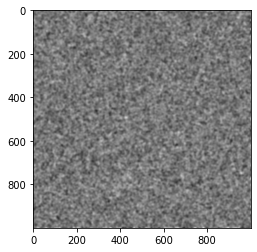

In [3]:
bg_source = np.random.rand(1000, 1000, 1).astype(np.float32)
bg_source = skimage.filters.gaussian(bg_source, 4)
bg_source = (bg_source - np.min(bg_source))/(np.max(bg_source) - np.min(bg_source))
bg_source = np.clip(bg_source, 0, 1)

plt.imshow(bg_source[..., 0], 'gray')

### Функция для конвертации MNIST в датасет для локализации
Реализуем функцию `convert_to_loc_ds`, в которую передается подвыборка (train или test) картинок из MNIST (x) и правильных классификационных ответов (y). Задача функции сгенерировать новый датасет, состоящий из картинок размера `new_size`. Для каждой новой картинки мы сначала возьмем случайный кусочек фона из `bg_source`, а затем поместим цифру из MNIST на случайное место в новой картинке.

В качестве Ground-Truth (истинных) данных для одного образца будем использовать матрицу размером 10x5, где 10 = количество классов, а 5 = 1+4 (вероятность данного класса + прямоугольник (бокс), соответствующий данному классу). Для истинного класса вероятность будет равна 1, а координаты прямоугольника соовтетствовать тому случайному месту, куда мы поместили цифру из MNIST. Для остальных классов вероятность будет равна 0, а в качестве прямоугольника мы возьмём невозможный прямоуголник с координатами [-1, -1, -1, -1] -- это будет дополниеьльный сигнал для модели, что на картинке нет соответствующего класса.

Кроме того, координаты прямоуголника обычно нормализуют относительно размеров картинки (`new_size`).

In [4]:
def convert_to_loc_ds(x, y, bg_source, new_size):
    x_new = np.zeros((x.shape[0], new_size[0], new_size[1], 1), dtype=np.float32)
    y_new = np.zeros((y.shape[0], 10, 5), dtype=np.float32)
    y_new[:, :, 1:] = -1

    rh = float(x.shape[1]) / new_size[0]
    rw = float(x.shape[2]) / new_size[1]

    for i in range(x.shape[0]):
        oh = random.randint(0, bg_source.shape[0] - new_size[0])
        ow = random.randint(0, bg_source.shape[1] - new_size[1])
        x_new[i] = bg_source[oh:oh+new_size[0], ow:ow+new_size[1], :]
        oh = random.randint(0, x_new[i,...].shape[0] - x[i].shape[0])
        ow = random.randint(0, x_new[i,...].shape[1] - x[i].shape[1])
        x_new[i, oh:oh+x[i].shape[0], ow:ow+x[i].shape[1], :] += x[i]
        x_new[i] = np.clip(x_new[i], 0, 1)
        ry = float(oh) / new_size[0]
        rx = float(ow) / new_size[1]
        y_new[i][y[i]] = [1.0, ry, rx, rh, rw]
        
    return x_new, y_new

### Генерация локализационного датасета
Сгенерируем локализационный датасет (train и test). Размер новых картинок (`new_size`) возьмем 64x64

In [5]:
new_size = (64, 64)

train_x_new, train_y_new = convert_to_loc_ds(train_x, train_y, bg_source, new_size)
test_x_new, test_y_new = convert_to_loc_ds(test_x, test_y, bg_source, new_size)

print(train_x_new.shape)
print(train_y_new.shape)
print(test_x_new.shape)
print(test_y_new.shape)

(60000, 64, 64, 1)
(60000, 10, 5)
(10000, 64, 64, 1)
(10000, 10, 5)


### Фнкция для отображения локализации
Реализуем функцию, которая по входной картинке и предсказанию (ground-truth или выход модели `logits`) визуализирует это предсказание на картинке.

In [6]:
def show_prediction(x, logits):
    import matplotlib.patches as patches

    pred_cls = np.argmax(logits[:,0])
    ry, rx, rh, rw = logits[pred_cls][1:]

    box_y = int(ry * x.shape[0])
    box_x = int(rx * x.shape[1])
    box_w = int(rw * x.shape[0])
    box_h = int(rh * x.shape[0])

    fig,ax = plt.subplots(1)
    ax.imshow(x[...,0], 'gray', vmin=0, vmax=1,)
    rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print('Prediction: {}'.format(pred_cls))
    print('Box: {}'.format((box_x, box_y, box_w, box_h)))

### Визуализация Ground-Truth образца

Prediction: 4
Box: (28, 27, 28, 28)


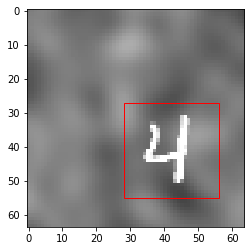

In [7]:
i = random.randint(0, train_x_new.shape[0])
show_prediction(train_x_new[i], train_y_new[i])

# Классиифкация и Локализация

### Создание модели для классификации и локализации
Теперь наш датасет готов, так что давайти создадим и обучим на нём модель для классификации и локализации. Создадим модель для классификации и локализации. Она будет очень похожа на обычную CNN для классификации, но здесь мы сделаем так, что выход из последнего слоя будет содержать не просто распределение веротяностей по классам, а еще и координаты прямоугольника для каждого класса. Итого 10*(1+4) чисел на выходе. Для удобства отделим в выходном тензоре размерностии, соответствующие классам и пятёрке, отвечающей за один класс (с помощью reshape). Таким образом, выходной тензор будет иметь размерность (количество образцов, количество классов, 5).

**[ЗАДАНИЕ 1]** Вопрос: Почему для такой архитектуры в последнем слое (`fc2`) мы не можем сразу указать функцию активации `softmax`, и нам приходится здсь использовать `None`, а softmax навешивать уже потом (в лоссе)?

In [8]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv4 = tf.keras.layers.Conv2D(128, (5, 5), activation=tf.nn.relu, padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(5*10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        
    def call(self, inp):
        
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = self.max_pool(out)
        out = self.conv4(out)
        out = self.max_pool(out)
        out = tf.layers.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = tf.reshape(out, (-1, out.shape[1]//5, 5))
        
        return out
    
model = Model()

### Функция потерь (Loss)
Зададим функцию потерь. В этом премере она будет не совсем стандартной. Так как теперь наша модель выдаёт и информацию про метку класса и информацию про ограничивающие прямоугольники, нам надо будет учесть и то и то. Для этого нам понадобятся два лосса: один для классификации (`loss_cls`), дургой для регрессии (`loss_box`). 

Каждый из этих лоссов будет применяться к определённой части тензоров, соответствующих выходу сети и Ground-Truth. Классификационный лосс будем применять для элементов `[:,:,0]`, а локализационный для элементов `[:,:,1:]`, ибо так мы пострили наш Ground-Truth. Для классификации будем применять `softmax_cross_entropy` (в этом лоссе нужен дополнительный софтмакс, так как мы не использовали софтмакс в самой модели). Для регрессии -- `mean_squared_error` (MSE).

Далее нам нужно будет получить единый лосс, как взвешеную сумму `loss_cls` и `loss_box`. За взвешивание будет отвечать параметр `LAMBDA`, величина которого будет отвечать за то, чему больше должна уделять внимание нейроннная сеть -- классификации или локализации. Это гиперпараметр.

**[ЗАДАНИЕ 2]** Вопрос: Каковы размеры тензора `logits_box`, при условии, что batch_size = 64?

In [9]:
def loss_cls(labels, logits):
    logits_cls = logits[:,:,0]
    labels_cls = labels[:,:,0]
    return tf.losses.softmax_cross_entropy(labels_cls, logits_cls)

def loss_box(labels, logits):
    logits_box = logits[:,:,1:]
    labels_box = labels[:,:,1:]
    return tf.losses.mean_squared_error(labels_box, logits_box)

LAMBDA = 10.0
def loss_composit(labels, logits):
    return loss_cls(labels, logits) + LAMBDA * loss_box(labels, logits)

### Обучение

**[ЗАДАНИЕ 3]** Реализуйте пайплайн обучения описанной выше модели `model`, как это делалось для других задач обучения в tensorFlow. Используйте созданные выше `train_x_new` и `train_y_new` в качестве обучающего датасета. Во время обучения минимизируйте композитный лосс `loss_composit`. Постройте график зависимости лосса от эпохи.

In [10]:
NUM_EPOCHS = 20
BATCH_SIZE = 64
# change LAMBDA to 10.0

model.compile(optimizer='adam', loss=loss_composit)

hist = model.fit(train_x_new, train_y_new, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

plt.plot(hist.history['loss'])

Epoch 1/20


AttributeError: ignored

### Тестирование модели
Возьмём случайный образец из нашей тестовой выборки и пропустим его через обученную модель. Визуализируем результат предсказания.

**[ЗАДАНИЕ 4]** Позапускайте этот блок и посмотрите, как работает обученая модель на различных тестовых изображениях.

Prediction: 8
Box: (29, 20, 30, 30)


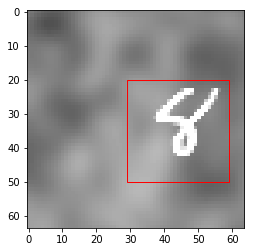

In [ ]:
i = random.randint(0, test_x_new.shape[0])
sample = test_x_new[i]
          
pred = model.predict(sample[None, ...])[0, ...]
show_prediction(sample, pred)

### Дополнительное задание
**[ЗАДАНИЕ 5]** Поэксперементируйте c гипермарамтерами модели и обучения для улучшения качества работы модели. Уделите внимание парамтеру LAMBDA и количеству эпох. Кроме того, попробуйте модифицировать архитектуру нейросети.